## TCR sequencing power analysis

I have simulated 1 million TCR sequences from which to sample to get an idea of how many cells we need to get an accurate representation of the TCR repetoire.  The only step in thymocyte development I have assumed is beta- and positive selection, i.e. there is a functional pair of alpha and beta chains in each T cell.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math
import itertools
import re

%matplotlib inline

In [4]:
infile = "~/Dropbox/AgeingExperiment/TCR_simulations/1Million_TCRs.txt"

# I need to randomly sample different numbers of TCRs from 100-100K, I'll use ~ 1/2 order of magnitude jumps with 
# a few extra's in between
n_total = 1000000
n_samples = [100, 500, 1000, 5000, 10000, 50000, 100000]

# for each sample randomly choose integer values between 0 and the number of cells to sample
sample_ints = [random.sample(range(n_total), x) for x in n_samples]
all_sampled = set(itertools.chain.from_iterable(sample_ints))

In [6]:
# read each line and pull out the sampled ones
chunksize = 10000
file_block = pd.read_table(infile, index_col=None, sep="\t", header=0, iterator=True,
                          chunksize=chunksize)
count = 0
sampled_df = []
for df_ in file_block:
    df_ = df_.loc[df_["Valid.TCR"].isin([True]), ]
    # select the line numbers in the 'all_sampled' list
    
    df_["LineNumber"] = range(count, count + df_.shape[0])
    df_ = df_.loc[df_.LineNumber.isin(all_sampled), :]
    
    if df_.shape[0] > 0:
        sampled_df.append(df_)
        
    count += df_.shape[0]

In [7]:
len(sampled_df)

395

In [8]:
# concatenate the data frames
sampled_data = pd.concat(sampled_df, axis=0)
sampled_data.shape

(156805, 28)

In [9]:
# now calculate different metrics and measures of diversity.  Firstly, CDR entropy
entropy_dict = {}
cdr3_len_dict = {}

vseg_use_dict = {}
jseg_use_dict = {}

chain_pairing_dict = {}
segment_pairing_dict = {}

tra_cdr3_clones = {}
trb_cdr3_clones = {}

for i in range(len(n_samples)):
    n_samp = n_samples[i]
    sample_lines = sample_ints[i]
    
    samp_df = sampled_data.loc[sampled_data.LineNumber.isin(sample_lines), ]
    
    entropy_dict[str(n_samp)] = pd.melt(pd.DataFrame({"alpha": samp_df.TRA_CDR3_entropy,
                                                      "beta": samp_df.TRB_CDR3_entropy}))
    
    cdr3_len_dict[str(n_samp)] = pd.melt(pd.DataFrame({"alpha": samp_df.TRB_CDR3.astype(str).apply(len),
                                                       "beta": samp_df.TRB_CDR3.astype(str).apply(len)}))
    
    # count the occurences of specific CDR3 sequences to get a total diversity
    tra_cdr3_clones[str(n_samp)] = samp_df.TRA_CDR3.value_counts()
    trb_cdr3_clones[str(n_samp)] = samp_df.TRB_CDR3.value_counts()
    
    # need calculate percentage rather than absolute counts
    vseg_use = pd.DataFrame({"alpha": samp_df.TRA_V.value_counts()/n_samp,
                             "beta": samp_df.TRB_V.value_counts()/n_samp})
    vseg_use.reset_index(inplace=True)
    vseg_use.columns = ["Segment", "alpha", "beta"]
    
    vseg_use_dict[str(n_samp)] = pd.melt(vseg_use, id_vars="Segment")
       
    jseg_use = pd.DataFrame({"alpha": samp_df.TRA_J.value_counts()/n_samp,
                             "beta": samp_df.TRB_J.value_counts()/n_samp})
    jseg_use.reset_index(inplace=True)
    jseg_use.columns = ["Segment", "alpha", "beta"]
    
    jseg_use_dict[str(n_samp)] = pd.melt(jseg_use, id_vars="Segment")
    
    # record the V and J pairing within a chain
    samp_df.loc[:, "AlphaPair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRA_J]), axis=1)
    samp_df.loc[:, "BetaPair"] = samp_df.apply(lambda X: "_".join([X.TRB_V, X.TRB_J]), axis=1)
    
    pair_use = pd.DataFrame({"alpha": samp_df.AlphaPair.value_counts()/n_samp,
                              "beta": samp_df.BetaPair.value_counts()/n_samp})
    pair_use.reset_index(inplace=True)
    pair_use.columns = ["Pair", "alpha", "beta"]
    
    segment_pairing_dict[str(n_samp)] = pd.melt(pair_use, id_vars="Pair")
    
    # record the V and J pairing between chains
    samp_df.loc[:, "Vpair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRB_V]), axis=1)
    samp_df.loc[:, "Jpair"] = samp_df.apply(lambda X: "_".join([X.TRA_J, X.TRB_J]), axis=1)
    
    chain_use = pd.DataFrame({"Vseg": samp_df.Vpair.value_counts()/n_samp,
                              "Jseg": samp_df.Jpair.value_counts()/n_samp})
    chain_use.reset_index(inplace=True)
    chain_use.columns = ["Pair", "Vseg", "Jseg"]
    
    chain_pairing_dict[str(n_samp)] = pd.melt(chain_use, id_vars="Pair")
    
    print(samp_df.shape)
    

/Users/morgan02/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/morgan02/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(86, 32)
(542, 32)
(1111, 32)
(4806, 32)
(9844, 32)
(49746, 32)
(98240, 32)


In [10]:
entropy_df = pd.concat(entropy_dict)
entropy_df.reset_index(inplace=True)
entropy_df.columns = ["Sample", "Level", "Chain", "Entropy"]
entropy_df.loc[entropy_df.Entropy.isna(), "Entropy"] = 0


length_df = pd.concat(cdr3_len_dict)
length_df.reset_index(inplace=True)
length_df.columns = ["Sample", "Level", "Chain", "Length"]
length_df.loc[length_df.Length.isna(), "Length"] = 0

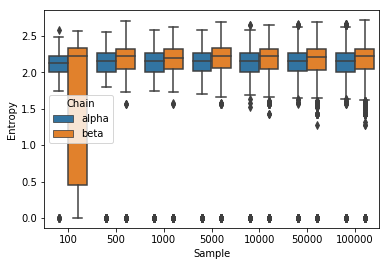

In [17]:
sns.boxplot(x="Sample", y="Entropy", data=entropy_df, hue="Chain",
            order=["100", "500", "1000", "5000", "10000", "50000", "100000"])
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/CDR3_entropy_power.png",
           height=4.25, width=6.75, dpi=300, bbox_inches='tight')

plt.show()

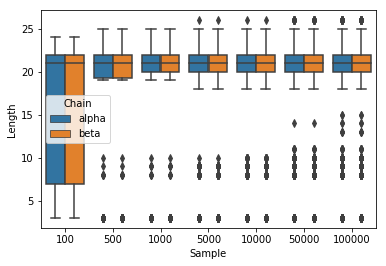

In [18]:
sns.boxplot(x="Sample", y="Length", data=length_df.loc[length_df.Length > 0], hue="Chain",
            order=["100", "500", "1000", "5000", "10000", "50000", "100000"])
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/CDR3_length_power.png",
           height=4.25, width=6.75, dpi=300, bbox_inches='tight')

plt.show()

In [19]:
vseg_df = pd.concat(vseg_use_dict)
vseg_df.reset_index(inplace=True)
vseg_df.columns = ["Sample", "Level", "Segment", "Chain", "Counts"]
# remove TRAV segments from the beta chains
vseg_df = vseg_df.loc[~((vseg_df["Chain"] == "beta") & (vseg_df["Segment"].str.contains("TRAV")))]
vseg_df = vseg_df.loc[~((vseg_df["Chain"] == "alpha") & (vseg_df["Segment"].str.contains("TRBV")))]
vseg_df.loc[vseg_df.Counts.isna(), "Counts"] = 0

In [20]:
set(vseg_df.Segment)

{'TRAV1',
 'TRAV10',
 'TRAV10D',
 'TRAV10N',
 'TRAV11',
 'TRAV11D',
 'TRAV12-1',
 'TRAV12-2',
 'TRAV12-3',
 'TRAV12D-1',
 'TRAV12D-2',
 'TRAV12D-3',
 'TRAV12N-1',
 'TRAV12N-2',
 'TRAV12N-3',
 'TRAV13-1',
 'TRAV13-2',
 'TRAV13-3',
 'TRAV13-4/DV7',
 'TRAV13-5',
 'TRAV13D-1',
 'TRAV13D-2',
 'TRAV13D-3',
 'TRAV13D-4',
 'TRAV13N-1',
 'TRAV13N-2',
 'TRAV13N-3',
 'TRAV14-1',
 'TRAV14-2',
 'TRAV14-3',
 'TRAV14D-1',
 'TRAV14D-2',
 'TRAV14D-3/DV8',
 'TRAV14N-1',
 'TRAV14N-2',
 'TRAV14N-3',
 'TRAV15-1/DV6-1',
 'TRAV15-2/DV6-2',
 'TRAV15D-1/DV6D-1',
 'TRAV15D-2/DV6D-2',
 'TRAV15N-1',
 'TRAV15N-2',
 'TRAV16',
 'TRAV16D/DV11',
 'TRAV16N',
 'TRAV17',
 'TRAV18',
 'TRAV19',
 'TRAV2',
 'TRAV21/DV12',
 'TRAV23',
 'TRAV3-1',
 'TRAV3-3',
 'TRAV3-4',
 'TRAV3D-2',
 'TRAV3D-3',
 'TRAV4-2',
 'TRAV4-3',
 'TRAV4-4/DV10',
 'TRAV4D-3',
 'TRAV4D-4',
 'TRAV4N-3',
 'TRAV4N-4',
 'TRAV5-1',
 'TRAV5-4',
 'TRAV5D-4',
 'TRAV5N-4',
 'TRAV6-1',
 'TRAV6-2',
 'TRAV6-3',
 'TRAV6-5',
 'TRAV6-6',
 'TRAV6-7/DV9',
 'TRAV6D-3',
 'T

In [ ]:
ax = sns.factorplot(x="Segment", y="Counts", data=vseg_df.loc[vseg_df["Chain"] == "alpha"], hue="Sample", 
                    kind="point", height=3, aspect=4.5, join=False, scale=1.5,
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="V segment", y_var="Percentage Used")

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Valpha-segment_use_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')
plt.show()

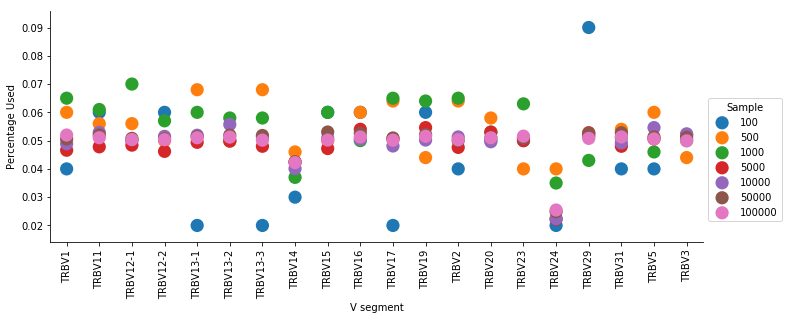

In [22]:
ax = sns.factorplot(x="Segment", y="Counts", data=vseg_df.loc[vseg_df["Chain"] == "beta"], hue="Sample", 
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5,
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="V segment", y_var="Percentage Used")

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Vbeta-segment_use_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')
plt.show()

In [23]:
jseg_df = pd.concat(jseg_use_dict)
jseg_df.reset_index(inplace=True)
jseg_df.columns = ["Sample", "Level", "Segment", "Chain", "Counts"]
# remove TRAV segments from the beta chains
jseg_df = jseg_df.loc[~((jseg_df["Chain"] == "beta") & (jseg_df["Segment"].str.contains("TRAJ")))]
jseg_df = jseg_df.loc[~((jseg_df["Chain"] == "alpha") & (jseg_df["Segment"].str.contains("TRBJ")))]
jseg_df.loc[jseg_df.Counts.isna(), "Counts"] = 0

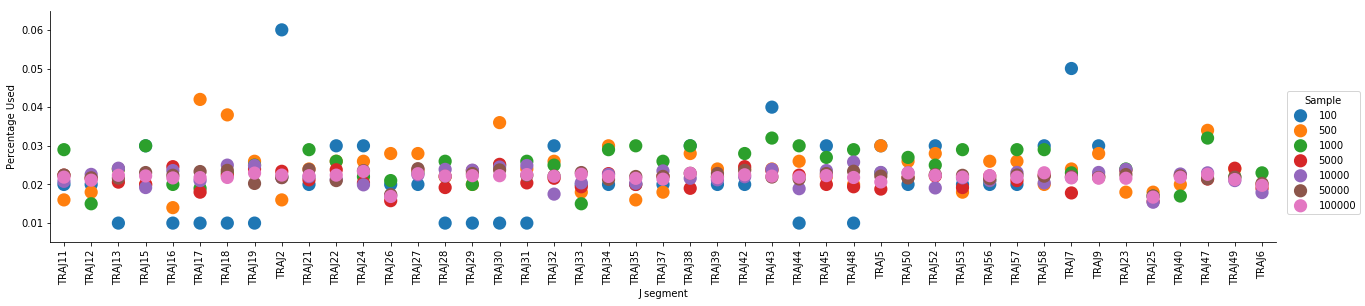

In [24]:
ax = sns.factorplot(x="Segment", y="Counts", data=jseg_df.loc[jseg_df["Chain"] == "alpha"], hue="Sample", 
                    kind="point", height=3, aspect=4.5, join=False, scale=1.5,
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment", y_var="Percentage Used")

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jalpha-segment_use_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')
plt.show()

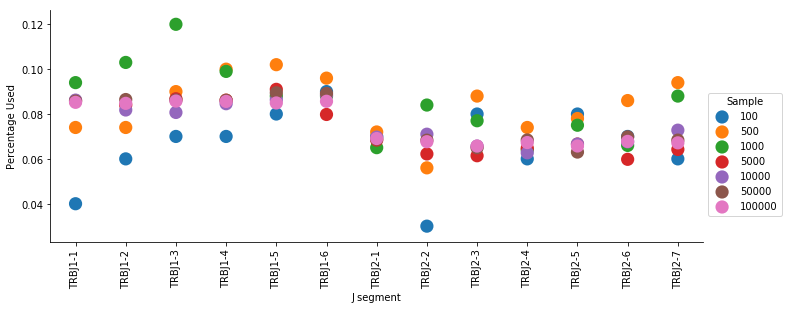

In [26]:
ax = sns.factorplot(x="Segment", y="Counts", data=jseg_df.loc[jseg_df["Chain"] == "beta"], hue="Sample", 
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5, 
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment", y_var="Percentage Used")

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jbeta-segment_use_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')
plt.show()

In [27]:
traj_segs = set(jseg_df.Segment.loc[jseg_df.Segment.str.contains("TRAJ")].values)
trbj_segs = set(jseg_df.Segment.loc[jseg_df.Segment.str.contains("TRBJ")].values)

trav_segs = set(vseg_df.Segment.loc[vseg_df.Segment.str.contains("TRAV")].values)
trbv_segs = set(vseg_df.Segment.loc[vseg_df.Segment.str.contains("TRBV")].values)

v_combs = ["_".join(v) for v in itertools.product(trav_segs, trbv_segs)]
j_combs = ["_".join(j) for j in itertools.product(traj_segs, trbj_segs)]

alpha_combs = ["_".join(av) for av in itertools.product(trav_segs, traj_segs)]
beta_combs = ["_".join(bv) for bv in itertools.product(trbv_segs, trbj_segs)]

In [28]:
# Ideally we want to calculate how much each deviates from the 'truth' or
# plot the value for the 1 million TCRs as well
# read each line and pull out the sampled ones
chunksize = 10000
file_block = pd.read_table(infile, index_col=None, sep="\t", header=0, iterator=True,
                          chunksize=chunksize)
count = 0
sampled_df = []
counter = 0

vseg_dict = {}
jseg_dict = {}

seg_pair_dict = {"J": pd.Series(dict(zip(j_combs, np.zeros(len(j_combs))))),
                 "V": pd.Series(dict(zip(v_combs, np.zeros(len(v_combs)))))}

chain_pair_dict = {"alpha": pd.Series(dict(zip(alpha_combs, np.zeros(len(alpha_combs))))),
                   "beta": pd.Series(dict(zip(beta_combs, np.zeros(len(beta_combs)))))}

for df_ in file_block:
    df_ = df_.loc[df_["Valid.TCR"].isin([True]), ]
    
    # record the V and J pairing within a chain
    df_.loc[:, "AlphaPair"] = df_.apply(lambda X: "_".join([X.TRA_V, X.TRA_J]), axis=1)
    df_.loc[:, "BetaPair"] = df_.apply(lambda X: "_".join([X.TRB_V, X.TRB_J]), axis=1)

    # record the V and J pairing between chains
    df_.loc[:, "Vpair"] = df_.apply(lambda X: "_".join([X.TRA_V, X.TRB_V]), axis=1)
    df_.loc[:, "Jpair"] = df_.apply(lambda X: "_".join([X.TRA_J, X.TRB_J]), axis=1)
    
    trav_counts = df_.TRA_V.value_counts()
    traj_counts = df_.TRA_J.value_counts()
    
    trbv_couts = df_.TRB_V.value_counts()
    trbj_counts = df_.TRB_J.value_counts()
    
    alpha_pair = df_.AlphaPair.value_counts()
    alpha_pair[alpha_pair.isna()] = 0
    
    beta_pair = df_.BetaPair.value_counts()
    beta_pair[beta_pair.isna()] = 0
    
    v_pair = df_.Vpair.value_counts()
    v_pair[v_pair.isna()] = 0
    
    j_pair = df_.Jpair.value_counts()
    j_pair[j_pair.isna()] = 0
    
    # V segments
    try:
        trav_counts = vseg_dict["alpha"] + trav_counts
        
        #vseg_dict["alpha"] = vseg_dict["alpha"].append(trav_counts)
    except KeyError:
        vseg_dict["alpha"] = trav_counts
    
    try:
        vseg_dict["beta"] = vseg_dict["beta"] + trbv_couts
        #vseg_dict["beta"] = vseg_dict["beta"].append(trbv_couts)
    except KeyError:
        vseg_dict["beta"] = trbv_couts
        
    # J segments
    try:
        jseg_dict["alpha"] = jseg_dict["alpha"] + traj_counts
        #jseg_dict["alpha"] = jseg_dict["alpha"].append(traj_counts)
    except KeyError:
        jseg_dict["alpha"] = traj_counts
        
    try:
        jseg_dict["beta"] = jseg_dict["beta"] + trbj_counts
        #jseg_dict["beta"] = jseg_dict["beta"].append(trbj_counts)
    except KeyError:
        jseg_dict["beta"] = trbj_counts

    try:
        if counter > 2:
            break
        # get already observed combinations
        #seen_v = set(seg_pair_dict["V"].index)
        #seg_pair_dict["V"] = seg_pair_dict["V"] + v_pair.loc[v_pair.index.isin(seen_v)]
        #seg_pair_dict["V"] = seg_pair_dict["V"].append(v_pair.loc[~v_pair.index.isin(seen_v)])
        seg_pair_dict["V"].update(v_pair)
    except KeyError:
        seg_pair_dict["V"] = v_pair
        
    try:
        # get already observed combinations
        #seen_j = set(seg_pair_dict["J"].index)
        #seg_pair_dict["J"] = seg_pair_dict["J"] + j_pair.loc[j_pair.index.isin(seen_j)]
        #seg_pair_dict["J"] = seg_pair_dict["J"].append(j_pair.loc[~j_pair.index.isin(seen_j)])
        seg_pair_dict["J"].update(j_pair)
    except KeyError:
        seg_pair_dict["J"] = j_pair
        
    try:
        # get already observed combinations
        chain_pair_dict["alpha"].update(alpha_pair)
    except KeyError:
        chain_pair_dict["alpha"] = alpha_pair
        
    try:
        # get already observed combinations
        chain_pair_dict["beta"].update(beta_pair)
    except KeyError:
        chain_pair_dict["beta"] = beta_pair
    
    count += df_.shape[0]
    counter += 1
    
    if counter > 5:
        break

In [29]:
jpair_1m_df = pd.DataFrame(seg_pair_dict)
jpair_1m_df.reset_index(inplace=True)
jpair_1m_df.head()

,index,J,V
0,TRAJ11_TRBJ1-1,4.0,NaN
1,TRAJ11_TRBJ1-2,7.0,NaN
2,TRAJ11_TRBJ1-3,3.0,NaN
3,TRAJ11_TRBJ1-4,5.0,NaN
4,TRAJ11_TRBJ1-5,7.0,NaN


In [30]:
jseg_1m_df = pd.DataFrame(jseg_dict)
jseg_1m_df.reset_index(inplace=True)
jseg_1m_df.columns = ["Segment", "alpha", "beta"]
jseg_1m_df = pd.melt(jseg_1m_df, id_vars="Segment")
jseg_1m_df.columns = ["Segment", "Chain", "Counts"]
jseg_1m_df["Sample"] = "1Million"
jseg_1m_df["Counts"] = jseg_1m_df.Counts/count

jseg_1m_df = jseg_1m_df.loc[~((jseg_1m_df["Chain"] == "beta") & (jseg_1m_df["Segment"].str.contains("TRAJ")))]
jseg_1m_df = jseg_1m_df.loc[~((jseg_1m_df["Chain"] == "alpha") & (jseg_1m_df["Segment"].str.contains("TRBJ")))]
jseg_1m_df.loc[jseg_1m_df.Counts.isna(), "Counts"] = 0

# V segments
vseg_1m_df = pd.DataFrame(vseg_dict)
vseg_1m_df.reset_index(inplace=True)
vseg_1m_df.columns = ["Segment", "alpha", "beta"]
vseg_1m_df = pd.melt(vseg_1m_df, id_vars="Segment")
vseg_1m_df.columns = ["Segment", "Chain", "Counts"]
vseg_1m_df["Sample"] = "1Million"
vseg_1m_df["Counts"] = vseg_1m_df.Counts/count

vseg_1m_df = vseg_1m_df.loc[~((vseg_1m_df["Chain"] == "beta") & (vseg_1m_df["Segment"].str.contains("TRAV")))]
vseg_1m_df = vseg_1m_df.loc[~((vseg_1m_df["Chain"] == "alpha") & (vseg_1m_df["Segment"].str.contains("TRBV")))]
vseg_1m_df.loc[vseg_1m_df.Counts.isna(), "Counts"] = 0

In [31]:
# concatenate with 1million
jseg_all = jseg_1m_df.append(jseg_df.loc[:, ["Chain", "Counts", "Sample", "Segment"]])
jseg_all.loc[jseg_all.Counts.isna(), "Counts"] = 0
jseg_all.head()

# concatenate with 1million
vseg_all = vseg_1m_df.append(vseg_df.loc[:, ["Chain", "Counts", "Sample", "Segment"]])
vseg_all.loc[vseg_all.Counts.isna(), "Counts"] = 0
vseg_all.head()

,Chain,Counts,Sample,Segment
0,alpha,0.003274,1Million,TRAV1
1,alpha,0.003274,1Million,TRAV10
2,alpha,0.003405,1Million,TRAV10D
3,alpha,0.003405,1Million,TRAV10N
4,alpha,0.003536,1Million,TRAV11


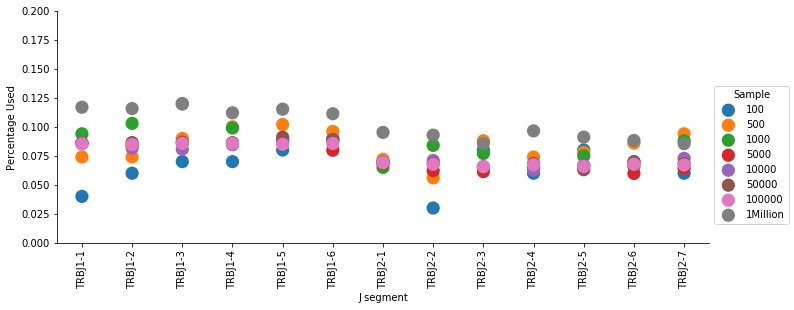

In [32]:
ax = sns.factorplot(x="Segment", y="Counts", data=jseg_all.loc[jseg_all["Chain"] == "beta"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000", "1Million"],
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment", y_var="Percentage Used")

ax.set(ylim=(0, 0.2))
plt.show()

In [33]:
jseg_cast = jseg_all.pivot(index="Segment", columns="Sample", values="Counts") 
# calculate the deviation from the 1million value
jseg_cast[jseg_cast.isna()] = 0
jseg_deviate = jseg_cast.apply(lambda X: abs(jseg_cast["1Million"] - X), axis=0)
#jseg_deviate.loc[jseg_deviate.isna()] = 0
jseg_deviate["Chain"] = "None"
jseg_deviate.loc[jseg_deviate.index.str.contains("TRA"), "Chain"] = "alpha"
jseg_deviate.loc[jseg_deviate.index.str.contains("TRB"), "Chain"] = "beta"
jseg_deviate.reset_index(inplace=True)

jseg_melt = pd.melt(jseg_deviate, id_vars=["Chain", "Segment"])
# dropt the 1 million sample
jseg_melt = jseg_melt.loc[~jseg_melt.Sample.str.contains("1Million"), :]
jseg_melt.head()

,Chain,Segment,Sample,value
0,alpha,TRAJ11,100,0.009859
1,alpha,TRAJ12,100,0.009204
2,alpha,TRAJ13,100,0.019073
3,alpha,TRAJ15,100,0.001037
4,alpha,TRAJ16,100,0.016977


In [34]:
vseg_cast = vseg_all.pivot(index="Segment", columns="Sample", values="Counts") 
# calculate the deviation from the 1million value
vseg_cast[vseg_cast.isna()] = 0
vseg_deviate = vseg_cast.apply(lambda X: abs(vseg_cast["1Million"] - X), axis=0)
#jseg_deviate.loc[jseg_deviate.isna()] = 0
vseg_deviate["Chain"] = "None"
vseg_deviate.loc[vseg_deviate.index.str.contains("TRA"), "Chain"] = "alpha"
vseg_deviate.loc[vseg_deviate.index.str.contains("TRB"), "Chain"] = "beta"
vseg_deviate.reset_index(inplace=True)

vseg_melt = pd.melt(vseg_deviate, id_vars=["Chain", "Segment"])
# dropt the 1 million sample
vseg_melt = vseg_melt.loc[~vseg_melt.Sample.str.contains("1Million"), :]
vseg_melt.head()

,Chain,Segment,Sample,value
0,alpha,TRAV1,100,0.006726
1,alpha,TRAV10,100,0.003274
2,alpha,TRAV10D,100,0.016595
3,alpha,TRAV10N,100,0.003405
4,alpha,TRAV11,100,0.003536


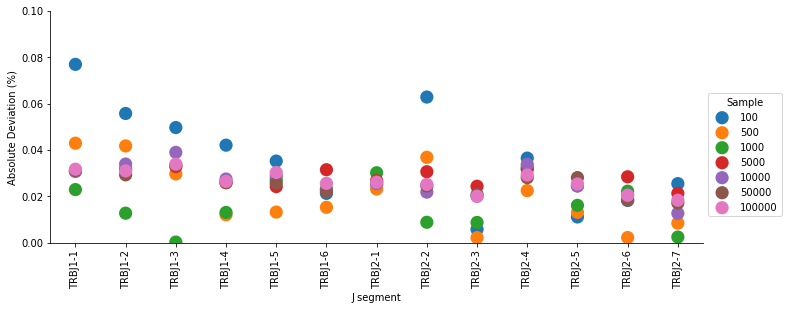

In [35]:
ax = sns.factorplot(x="Segment", y="value", data=jseg_melt.loc[jseg_melt["Chain"] == "beta"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment", y_var="Absolute Deviation (%)")

ax.set(ylim=(0, 0.1))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jbeta-segment_deviation_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

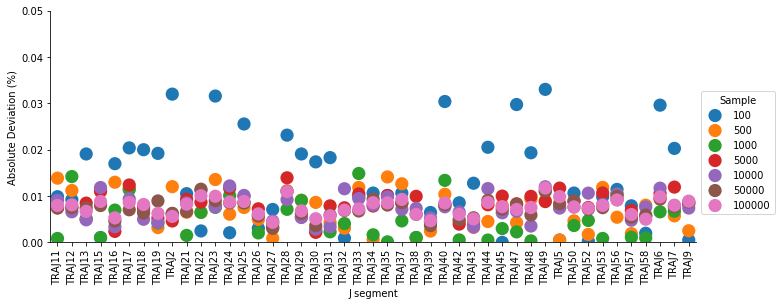

In [36]:
ax = sns.factorplot(x="Segment", y="value", data=jseg_melt.loc[jseg_melt["Chain"] == "alpha"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment", y_var="Absolute Deviation (%)")

ax.set(ylim=(0, 0.05))
plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jalpha-segment_deviation_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

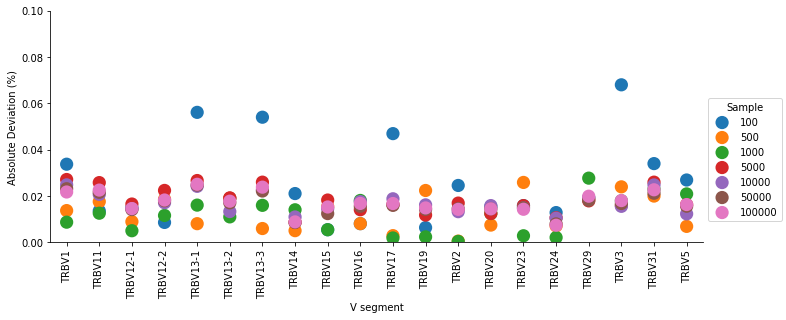

In [37]:
ax = sns.factorplot(x="Segment", y="value", data=vseg_melt.loc[vseg_melt["Chain"] == "beta"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=2.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="V segment", y_var="Absolute Deviation (%)")

ax.set(ylim=(0, 0.1))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Vbeta-segment_deviation_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

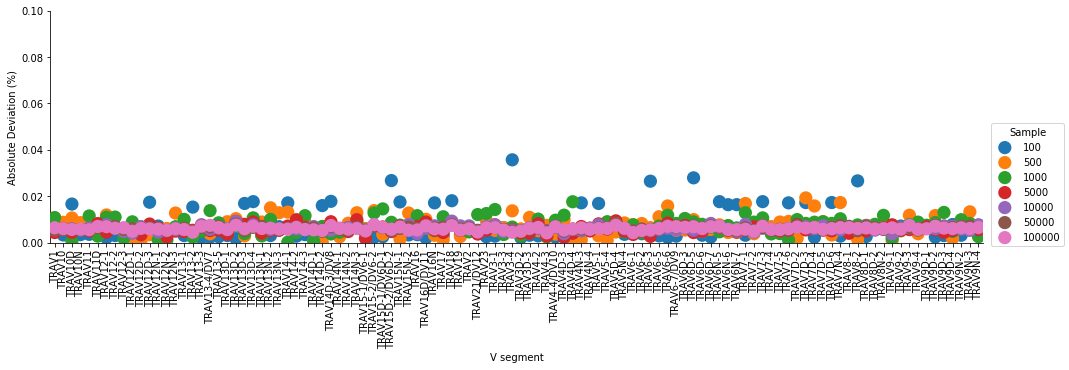

In [38]:
ax = sns.factorplot(x="Segment", y="value", data=vseg_melt.loc[vseg_melt["Chain"] == "alpha"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=3.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="V segment", y_var="Absolute Deviation (%)")

ax.set(ylim=(0, 0.1))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Valpha-segment_deviation_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

In [39]:
jpair_1m_df = pd.DataFrame(seg_pair_dict)
jpair_1m_df.reset_index(inplace=True)
jpair_1m_df.columns = ["Pair", "J", "V"]
jpair_1m_df = pd.melt(jpair_1m_df, id_vars="Pair")
jpair_1m_df.columns = ["Pair", "Segment", "Counts"]
jpair_1m_df["Sample"] = "1Million"
jpair_1m_df["Counts"] = jpair_1m_df.Counts/count

jpair_1m_df = jpair_1m_df.loc[~((jpair_1m_df["Segment"] == "J") & (jpair_1m_df["Pair"].str.contains("V")))]
jpair_1m_df = jpair_1m_df.loc[~((jpair_1m_df["Segment"] == "V") & (jpair_1m_df["Pair"].str.contains("J")))]
jpair_1m_df.loc[jpair_1m_df.Counts.isna(), "Counts"] = 0

# remove pairs that are never observed
jpair_1m_df = jpair_1m_df.loc[jpair_1m_df.Counts >= 0]
jpair_1m_df.head()

,Pair,Segment,Counts,Sample
0,TRAJ11_TRBJ1-1,J,0.000524,1Million
1,TRAJ11_TRBJ1-2,J,0.000917,1Million
2,TRAJ11_TRBJ1-3,J,0.000393,1Million
3,TRAJ11_TRBJ1-4,J,0.000655,1Million
4,TRAJ11_TRBJ1-5,J,0.000917,1Million


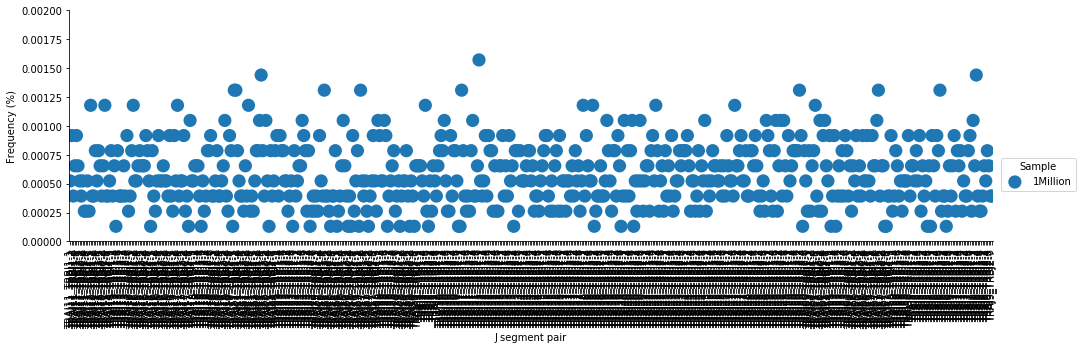

In [40]:
ax = sns.factorplot(x="Pair", y="Counts", data=jpair_1m_df.loc[jpair_1m_df["Segment"] == "J"], hue="Sample",
                    #hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=3.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="J segment pair", y_var="Frequency (%)")

ax.set(ylim=(0, 0.002))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Jpairing-1million_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

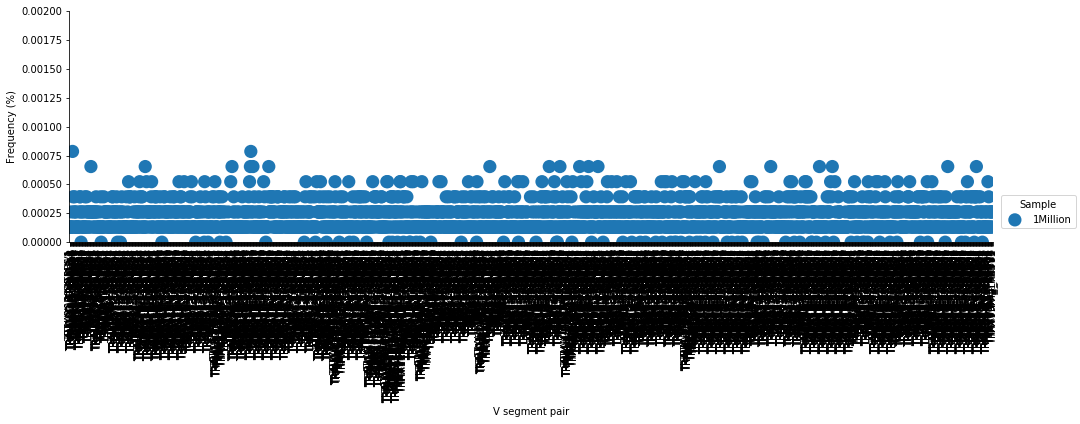

In [41]:
ax = sns.factorplot(x="Pair", y="Counts", data=jpair_1m_df.loc[jpair_1m_df["Segment"] == "V"], hue="Sample",
                    #hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=3.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="V segment pair", y_var="Frequency (%)")

ax.set(ylim=(0, 0.002))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Vpairing-1million_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()

In [42]:
chain_df = pd.concat(chain_pairing_dict)
chain_df.reset_index(inplace=True)
chain_df.columns = ["Sample", "Level", "Pair", "Segment", "Frequency"]
chain_df.loc[chain_df.Frequency.isna(), "Frequency"] = 0

chain_df.head()

,Sample,Level,Pair,Segment,Frequency
0,100,0,TRAJ11_TRBJ2-3,Vseg,0.01
1,100,1,TRAJ11_TRBJ2-7,Vseg,0.01
2,100,2,TRAJ12_TRBJ1-4,Vseg,0.01
3,100,3,TRAJ12_TRBJ2-2,Vseg,0.01
4,100,4,TRAJ13_TRBJ2-1,Vseg,0.01


In [48]:
# similarity of CDR3 sequences is what is _most_ interesting in terms of estimating diversity
# it might be better to figure out how to collapse down similar CDR3 clonotypes
simpson_dict_alpha = {}
for x in tra_cdr3_clones.keys():
    n_counts = tra_cdr3_clones[x]
    nume = n_counts * (n_counts - 1)
    denom = sum(n_counts) * (sum(n_counts) - 1)
    simp_div = 1 - (sum(nume/denom))
    simpson_dict_alpha[x] = simp_div
    
simpson_dict_beta = {}
for x in trb_cdr3_clones.keys():
    n_counts = trb_cdr3_clones[x]
    nume = n_counts * (n_counts - 1)
    denom = sum(n_counts) * (sum(n_counts) - 1) 
    simp_div = 1 - (sum(nume/denom))
    simpson_dict_beta[x] = simp_div

In [49]:
simpson_dict_beta

{'100': 1.0,
 '1000': 0.9999975281176616,
 '10000': 0.9999922235208942,
 '100000': 0.9999903513160625,
 '500': 0.999967474386079,
 '5000': 0.9999873928937681,
 '50000': 0.9999907016517572}

In [63]:
# calculate the entropy within a sample at each sample size
# use the CDR3 clonotype frequency for the Shannon entropy calculation

entropy_dict_alpha = {}
for x in tra_cdr3_clones.keys():
    n_counts = tra_cdr3_clones[x]
    n_freqs = n_counts/sum(n_counts)
    log_freq = np.log2(n_freqs)
    entropy = -sum(n_freqs * log_freq)
    entropy_dict_alpha[x] = entropy
    
entropy_dict_beta = {}
for x in trb_cdr3_clones.keys():
    n_counts = trb_cdr3_clones[x]
    n_freqs = n_counts/sum(n_counts)
    log_freq = np.log2(n_freqs)
    entropy = -sum(n_freqs * log_freq)
    entropy_dict_beta[x] = entropy

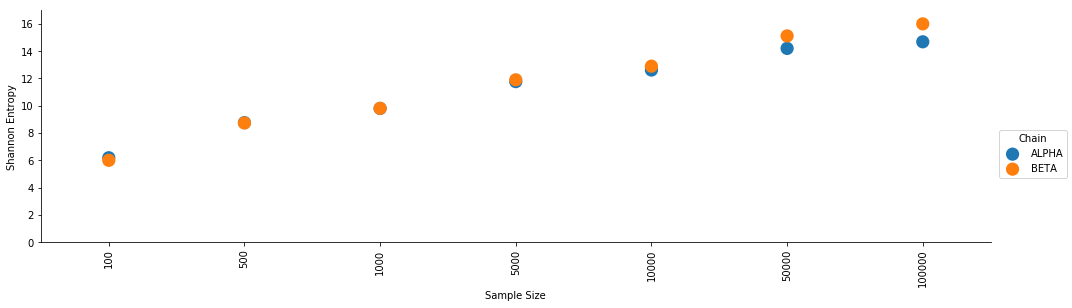

In [81]:
entropy_df = pd.DataFrame({"BETA": pd.Series(entropy_dict_beta), "ALPHA": pd.Series(entropy_dict_alpha)})
entropy_df["NSize"] = entropy_df.index.astype(np.int64)
entropy_melt = pd.melt(entropy_df, id_vars="NSize")
entropy_melt.columns = ["NSize", "Chain", "Entropy"]

ax = sns.factorplot(x="NSize", y="Entropy", data=entropy_melt, hue="Chain",
                    #hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=3.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="Sample Size", y_var="Shannon Entropy")
ax.set(ylim=(0, 17))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Entropy_power.png",
           height=4.25, width=3.25, dpi=300, bbox_inches='tight')

plt.show()

In [70]:
entropy_melt

,NSize,variable,value
0,100,ALPHA,6.189825
1,1000,ALPHA,9.803927
2,10000,ALPHA,12.618841
3,100000,ALPHA,14.688777
4,500,ALPHA,8.764504
5,5000,ALPHA,11.770179
6,50000,ALPHA,14.203840
7,100,BETA,6.000000
8,1000,BETA,9.811559
9,10000,BETA,12.903070


In [45]:
# pairing of V and J segments
# rather than assessing whether each specific pair is observed, rather look for the ones that are missing in 
# each sample  
chain_pair_df = pd.concat(segment_pairing_dict)
chain_pair_df.reset_index(inplace=True)
chain_pair_df.columns = ["Sample", "Level", "Pair", "Chain", "Frequency"]

chain_pair_df.shape

(40288, 5)

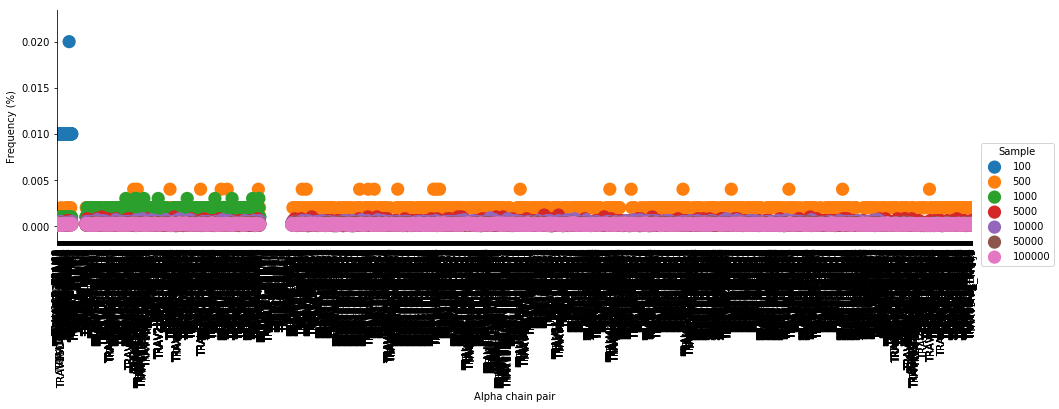

In [46]:
ax = sns.factorplot(x="Pair", y="Frequency", data=chain_pair_df.loc[chain_pair_df["Chain"] == "alpha"], hue="Sample",
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    kind="point", height=3, aspect=3.5, join=False, scale=1.5, 
                    sharex=False, sharey=False)

ax.set_xticklabels(rotation=90)
ax.set_axis_labels(x_var="Alpha chain pair", y_var="Frequency (%)")

#ax.set(ylim=(0, 0.002))

plt.savefig("/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/Alpha_pairing_power.png",
           height=4.25, width=15.25, dpi=300, bbox_inches='tight')

plt.show()